# Test notebook for Acceptance Test Campaign related to LSST Science Pipelines Release 20.0

This test will be executed on the LSST Science Platform Notebook Aspect, initialized with Science Pipelines release `r20-0-0`.

### Test case LVV-T125: Verify implementation of Simulated Data
Verify that the DMS can inject simulated data into data products for testing.

In [1]:
# Confirm that the version of the Science Pipelines is v20_0_0:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-r20-0-0
lsst_distrib          20.0.0     	current v20_0_0 setup


In [2]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)

In [4]:
zscale = ZScaleInterval()

# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 12})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

We will use HSC-RC2, as processed using `v20_0_0_rc1`, which is the pipelines version that was used to create `v20_0_0`.

In [5]:
# The output repo is tagged with the Jira ticket number "DM-26226":
rc2_repo_mb = '/datasets/hsc/repo/rerun/RCfakes/w_2020_36/DM-26711-multiBand'
# Initialize the butler repo:
butler_mb = dafPersist.Butler(rc2_repo_mb)

In [6]:
# The output repo is tagged with the Jira ticket number "DM-26226":
rc2_repo_coadd = '/datasets/hsc/repo/rerun/RC/w_2020_36/DM-26637'
# Initialize the butler repo:
butler_coadd = dafPersist.Butler(rc2_repo_coadd)

### Check for both a visit image and a coadd:

In [7]:
# Select an arbitrary source catalog from a deepCoadd_calexp:
filter = 'HSC-I'
# Coadd
tract = 9813
patch = '5,3'

In [8]:
dataIdCoadd = {'tract':tract, 'filter':filter, 'patch':patch}
forced_src = butler_mb.get('deepCoadd_forced_src', dataId = dataIdCoadd)
forced_src_ref = butler_mb.get('deepCoadd_ref', dataId = dataIdCoadd)
fakes_img = butler_mb.get('fakes_deepCoadd_calexp', dataId = dataIdCoadd)

In [9]:
calexp_img = butler_coadd.get('deepCoadd_calexp', dataId = dataIdCoadd)
forced_src_orig = butler_coadd.get('deepCoadd_forced_src', dataId = dataIdCoadd)

In [10]:
# Extract the images and normalize them:
im = calexp_img.image.array

# Create an ImageNormalize object
norm = ImageNormalize(im, interval=ZScaleInterval(),
                      stretch=LinearStretch())

fakes_im = fakes_img.image.array

# Create an ImageNormalize object
fakesnorm = ImageNormalize(fakes_im, interval=ZScaleInterval(),
                           stretch=LinearStretch())

diff = fakes_im - im

### Compare the original calexp, the calexp with fakes, and the difference (i.e., the fakes alone)

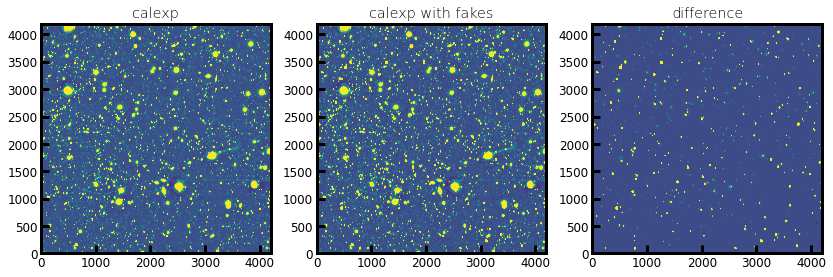

In [11]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.figure()

plt.subplot(131)
plt.imshow(im, norm=norm, origin='lower')
plt.title('calexp')

plt.subplot(132)
plt.imshow(fakes_im, norm=fakesnorm, origin='lower')
plt.title('calexp with fakes')

plt.subplot(133)
plt.imshow(diff, norm=fakesnorm, origin='lower')
plt.title('difference')

plt.show()

### Same comparison, but zoomed in closer

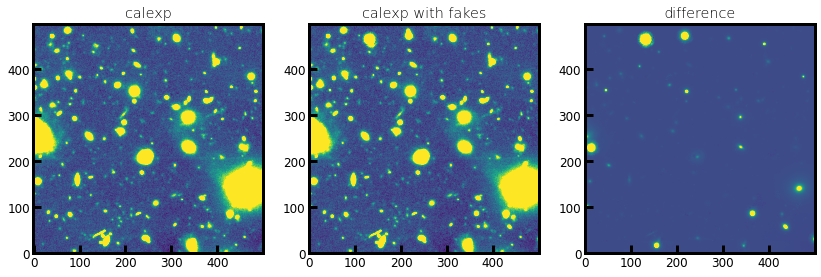

In [12]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.figure()

plt.subplot(131)
plt.imshow(im[1000:1500, 1000:1500], norm=norm, origin='lower')
plt.title('calexp')

plt.subplot(132)
plt.imshow(fakes_im[1000:1500, 1000:1500], norm=fakesnorm, origin='lower')
plt.title('calexp with fakes')

plt.subplot(133)
plt.imshow(diff[1000:1500, 1000:1500], norm=fakesnorm, origin='lower')
plt.title('difference')

plt.show()

In [13]:
fakeSourceCat = butler_mb.get('deepCoadd_fakeSourceCat', dataId = dataIdCoadd)

In [14]:
# Convert source catalog to Pandas dataframe:
df = fakeSourceCat.toDataFrame()

In [15]:
dsts = butler_mb.getDatasetTypes()
for d in dsts:
    # if 'deepCoadd' in d:
    if 'ref' in d:
        print(d)

deepCoadd_ref_filename
dcrCoadd_ref_md
deepCoadd_ref_schema
deepCoadd_ref
ref_cat_config
deepCoadd_ref_schema_filename
deepCoadd_ref_md
ref_cat_filename
dcrCoadd_ref_schema
ref_cat
ref_cat_md
dcrCoadd_ref_schema_filename
dcrCoadd_ref_schema_md
dcrCoadd_ref_filename
deepCoadd_ref_len
ref_cat_schema
deepCoadd_ref_schema_len
deepCoadd_ref_schema_md
dcrCoadd_ref_len
dcrCoadd_ref
ref_cat_len
ref_cat_config_filename
dcrCoadd_ref_schema_len


In [16]:
print(len(forced_src), len(forced_src_orig))

30133 26476


In [17]:
sch = forced_src.schema

In [18]:
for s in sch.getNames():
    if 'fake' in s:
        print(s)

base_PixelFlags_flag_fake
base_PixelFlags_flag_fakeCenter


### Use this flag to select objects overlapping the fake sources:

In [19]:
isfake = (forced_src['base_PixelFlags_flag_fakeCenter'] == True)

In [20]:
np.sum(isfake)

11008

In [21]:
xy0 = calexp_img.getXY0()

In [22]:
cutout_size = 750
inbox = (forced_src['base_SdssCentroid_x']-xy0[0] < cutout_size) & (forced_src['base_SdssCentroid_y']-xy0[1] < cutout_size)

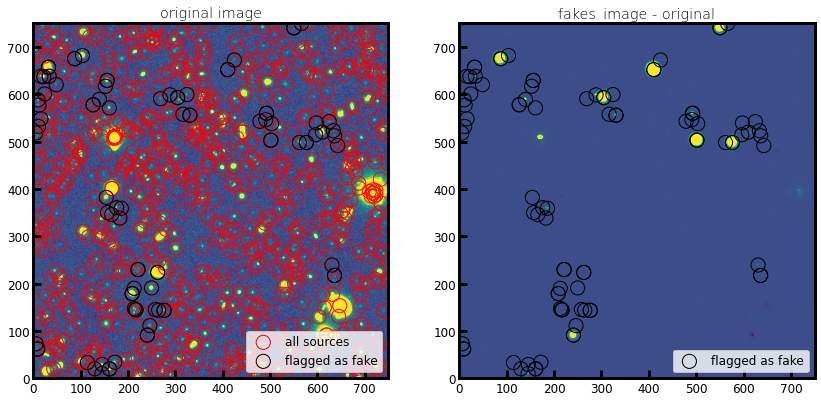

In [23]:
plt.rcParams.update({'figure.figsize' : (14, 7)})
plt.rcParams.update({'font.size' : 12})

plt.figure()

plt.subplot(121)
plt.imshow(im[0:cutout_size, 0:cutout_size], norm=norm, origin='lower')
plt.scatter(forced_src[inbox]['base_SdssCentroid_x']-xy0[0], forced_src[inbox]['base_SdssCentroid_y']-xy0[1],\
            s=200, edgecolor='red',facecolor='None', label='all sources')
plt.scatter(forced_src[inbox & isfake]['base_SdssCentroid_x']-xy0[0], forced_src[inbox & isfake]['base_SdssCentroid_y']-xy0[1],\
            s=200, edgecolor='black',facecolor='None', label='flagged as fake')
plt.legend(loc='lower right')
plt.xlim(0,cutout_size)
plt.ylim(0,cutout_size)
plt.title('original image')

plt.subplot(122)
plt.imshow(diff[0:cutout_size, 0:cutout_size], norm=norm, origin='lower')
#plt.scatter(forced_src[inbox]['base_SdssCentroid_x']-xy0[0], forced_src[inbox]['base_SdssCentroid_y']-xy0[1], s=200, edgecolor='red',facecolor='None')
plt.scatter(forced_src[inbox & isfake]['base_SdssCentroid_x']-xy0[0], forced_src[inbox & isfake]['base_SdssCentroid_y']-xy0[1],\
            s=200, edgecolor='black',facecolor='None', label='flagged as fake')
plt.legend(loc='lower right')
plt.xlim(0,cutout_size)
plt.ylim(0,cutout_size)
plt.title('fakes_image - original')

plt.show()

## Use spatial cuts to select the nearest object to each fake source

In [24]:
fake_cands = forced_src[isfake].copy(deep=True)

# Select only fakes within the ra, dec range of the patch we've chosen:
ramin = df.raJ2000 > np.min(fake_cands['coord_ra'])
ramax = df.raJ2000 < np.max(fake_cands['coord_ra'])
decmin = df.decJ2000 > np.min(fake_cands['coord_dec'])
decmax = df.decJ2000 < np.max(fake_cands['coord_dec'])

df_in_patch = df[ramin & ramax & decmin & decmax]

sc_fakes = SkyCoord(ra=df_in_patch.raJ2000.values*u.rad, dec=df_in_patch.decJ2000.values*u.rad)

In [25]:
# Initialize arrays of "-999" values to hold the indices
fake_indices = np.zeros(len(sc_fakes), dtype=int)-999
min_seps = np.zeros(len(sc_fakes))-999

#### Match the fakes and the measured sources that were flagged as fakes, using positions:

In [26]:
sc_cand = SkyCoord(ra=fake_cands['coord_ra']*u.rad, dec=fake_cands['coord_dec']*u.rad)

for i in range(len(sc_fakes)):
    sep = sc_fakes[i].separation(sc_cand)
    fake_indices[i] = int(np.where(sep == np.min(sep))[0][0])
    min_seps[i] = sep[np.where(sep == np.min(sep))[0][0]].to(u.arcsec).value

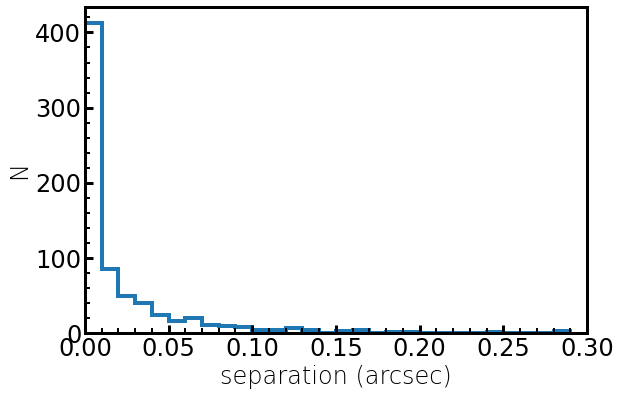

In [27]:
# Confirm that the matches are all at small separations:

plt.rcParams.update({'figure.figsize' : (9, 6)})
plt.rcParams.update({'font.size' : 24})
plt.hist(min_seps, bins=np.arange(0, 0.3, 0.01), histtype='step', linewidth=4)
plt.xlim(0, 0.3)
plt.xlabel('separation (arcsec)')
plt.ylabel('N')
plt.minorticks_on()
plt.show()

### Compare the input and recovered photometry for matched fake sources

In [28]:
photocalib = butler_coadd.get('deepCoadd_photoCalib', dataId = dataIdCoadd)
imags_meas = photocalib.instFluxToMagnitude(fake_cands, 'base_PsfFlux')

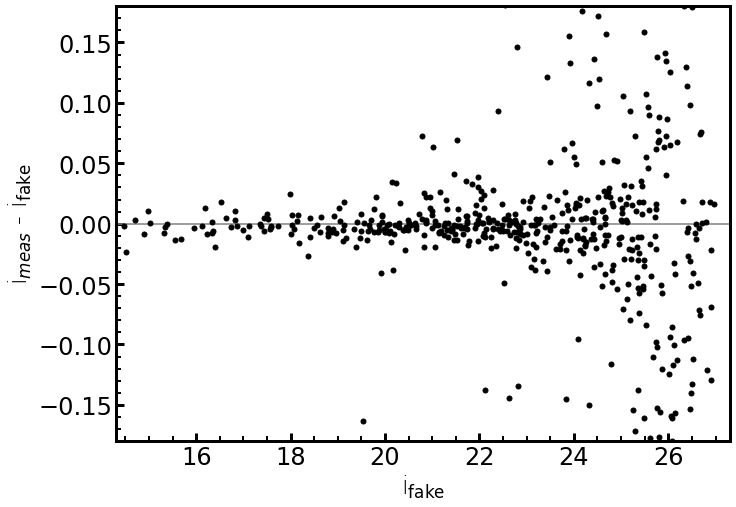

In [29]:
plt.rcParams.update({'figure.figsize' : (11, 8)})
plt.rcParams.update({'font.size' : 24})
plt.plot(df_in_patch.imag, imags_meas[fake_indices,0]-df_in_patch.imag, 'k.', ms=10)
plt.ylim(-0.18, 0.18)
plt.xlim(14.3, 27.3)
plt.hlines(0, 0, 30, color='gray')
plt.minorticks_on()
plt.xlabel(r'i$_{\rm fake}$')
plt.ylabel(r'i$_{meas}$ - i$_{\rm fake}$')
plt.show()

In [30]:
np.median(imags_meas[fake_indices,0]-df_in_patch.imag)

-0.0013153321486552016

The median offset is ~0.001 mag, so we'll say that the magnitudes are well recovered by the pipeline.